In [1]:
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from shutil import copyfile
import os
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

import tensorflow as tf
import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adamax

* As kaggle does not allow us to do any create, delete, or update within "/kaggle/input/" let's copy the dataset to working directory.
* Path of the working directory is "kaggle/working" and it is easily doable via magic commands..)

In [2]:
! rm -rf /kaggle/working/*

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


In [3]:
! cp -R /kaggle/input/lung-and-colon-cancer-histopathological-images/* /kaggle/working/

**Let's verity the data movement**

In [4]:
#List down all directories in "/kaggle/input/lung-and-colon-cancer-histopathological-images"
for dirName,_,fileName in os.walk("/kaggle/input/lung-and-colon-cancer-histopathological-images/lung_colon_image_set"):
    print(dirName)

/kaggle/input/lung-and-colon-cancer-histopathological-images/lung_colon_image_set
/kaggle/input/lung-and-colon-cancer-histopathological-images/lung_colon_image_set/colon_image_sets
/kaggle/input/lung-and-colon-cancer-histopathological-images/lung_colon_image_set/colon_image_sets/colon_aca
/kaggle/input/lung-and-colon-cancer-histopathological-images/lung_colon_image_set/colon_image_sets/colon_n
/kaggle/input/lung-and-colon-cancer-histopathological-images/lung_colon_image_set/lung_image_sets
/kaggle/input/lung-and-colon-cancer-histopathological-images/lung_colon_image_set/lung_image_sets/lung_aca
/kaggle/input/lung-and-colon-cancer-histopathological-images/lung_colon_image_set/lung_image_sets/lung_scc
/kaggle/input/lung-and-colon-cancer-histopathological-images/lung_colon_image_set/lung_image_sets/lung_n


In [5]:
#List down all directories in "/kaggle/working/"
for dirName,_,fileName in os.walk("/kaggle/working/lung_colon_image_set"):
    count = 0
    print("Directory:: ",dirName)

Directory::  /kaggle/working/lung_colon_image_set
Directory::  /kaggle/working/lung_colon_image_set/colon_image_sets
Directory::  /kaggle/working/lung_colon_image_set/colon_image_sets/colon_n
Directory::  /kaggle/working/lung_colon_image_set/colon_image_sets/colon_aca
Directory::  /kaggle/working/lung_colon_image_set/lung_image_sets
Directory::  /kaggle/working/lung_colon_image_set/lung_image_sets/lung_n
Directory::  /kaggle/working/lung_colon_image_set/lung_image_sets/lung_aca
Directory::  /kaggle/working/lung_colon_image_set/lung_image_sets/lung_scc


**Reading the data using ImageDataGenerator API of keras so we need to restructure the directory accordingly.**

In [6]:
! mkdir /kaggle/working/lung_colon_image_set/training/
! mkdir /kaggle/working/lung_colon_image_set/training/colon_aca/
! mkdir /kaggle/working/lung_colon_image_set/training/colon_n/
! mkdir /kaggle/working/lung_colon_image_set/training/lung_n/
! mkdir /kaggle/working/lung_colon_image_set/training/lung_aca/
! mkdir /kaggle/working/lung_colon_image_set/training/lung_scc/

! mkdir /kaggle/working/lung_colon_image_set/testing/
! mkdir /kaggle/working/lung_colon_image_set/testing/colon_aca/
! mkdir /kaggle/working/lung_colon_image_set/testing/colon_n/
! mkdir /kaggle/working/lung_colon_image_set/testing/lung_n/
! mkdir /kaggle/working/lung_colon_image_set/testing/lung_aca/
! mkdir /kaggle/working/lung_colon_image_set/testing/lung_scc/

In [7]:
def class_countPlot(datasets):
    # Check if 'datasets' is not a list and convert it to a list if needed
    if not isinstance(datasets, list):
        datasets = [datasets]  # Wrap it in a list
        
    class_counts = {}
    
    if datasets:
        for dataset in datasets:
            for folder in os.listdir(dataset):
                folder_path = os.path.join(dataset, folder)
                if os.path.isdir(folder_path):
                    files = os.listdir(folder_path)
                    images_count = len(files)
                    class_counts[folder] = images_count
                    
                else:
                    print(f"Folder {folder_path} does not exist.")

        # plotting the counts of each class
        class_names = list(class_counts.keys())
        counts = list(class_counts.values())
        
        # Get a colormap  
        cmap = plt.get_cmap("tab10")  # Choose a colormap (you can change 'viridis' to any other)  
        # Create a color for each count based on the colormap  
        colors = [cmap(i / len(counts)) for i in range(len(counts))]
        
        plt.figure(figsize=(10, 6))  
        plt.bar(class_names, counts, color= colors)  
        plt.xlabel('Classes')  
        plt.ylabel('Number of Images')  
        plt.title('Count of Images in Each Class')  
        plt.xticks(rotation=45)  
        plt.grid(axis='y')  
        
        # Show the plot  
        plt.tight_layout()  
        plt.show() 
        
    else:
        print("Warning: dataset(s) empty!!")

In [8]:
def split_data(source, training, testing, split_size):
    
    for folder in os.listdir(source):
        files = []
        folder_path = os.path.join(source, folder)
        
        for file in os.listdir(folder_path):
            file_path = os.path.join(folder_path, file)
            if os.path.getsize(file_path) > 0:
                files.append(file)
            else:
                print(file + "has not enough pixels to represent it as an image, seems corrupted so ignoring.")

        training_length = int(len(files) * split_size)
        testing_length = int(len(files) - training_length)
        training_set = shuffle(files[0: training_length])
        testing_set = shuffle(files[-testing_length:])

        for file in training_set:
            file_path = os.path.join(folder_path, file)
            destination_path = os.path.join(os.path.join(training, folder), file)
            copyfile(file_path, destination_path)
    
        for file in testing_set:
            file_path = os.path.join(folder_path, file)
            destination_path = os.path.join(os.path.join(testing, folder), file)
            copyfile(file_path, destination_path)

In [9]:
def plot_accuracy_loss(history):
    fig = plt.figure(figsize=(10,5))

    # Plot accuracy
    plt.subplot(221)
    plt.plot(history.history['accuracy'], label = "train")
    plt.plot(history.history['val_accuracy'], label = "validataion")
    plt.title("model accuracy")
    plt.ylabel("accuracy")
    plt.xlabel("epochs")
    plt.legend(loc = 'upper left')

    # Plot loss function
    plt.subplot(222)
    plt.plot(history.history['loss'], label = "loss")
    plt.plot(history.history['val_loss'], label = "val_loss")
    plt.title("model loss")
    plt.ylabel("loss")
    plt.xlabel("epochs")
    plt.legend(loc = 'upper left')
    plt.show()

**Parameters**

In [10]:
optimizer = Adamax(learning_rate= 0.001)
epochs = 100
img_size = (200, 200)
batch_size = 256
split_size = 0.8

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', 
                                                  patience=10, 
                                                  restore_best_weights=True
                                                 )
# ModelCheckpoint callback to save the best model weights  
model_checkpoint = tf.keras.callbacks.ModelCheckpoint("DenseNet_noTop_MRI.keras", # Path to save the model weights
                                                      monitor='val_accuracy',    # Which metric to monitor  
                                                      save_best_only=True,       # Save only the best model  
                                                      mode='max',                # We want to maximize the monitored metric  
                                                      verbose=1                  # Print a message when the model 
                                                    )


COLON_SOURCE_DIR = "/kaggle/working/lung_colon_image_set/colon_image_sets"
LUNG_SOURCE_DIR = "/kaggle/working/lung_colon_image_set/lung_image_sets"
TRAINING_DIR = "/kaggle/working/lung_colon_image_set/training"
TESTING_DIR = "/kaggle/working/lung_colon_image_set/testing"
DESTINATION = "/kaggle/working"

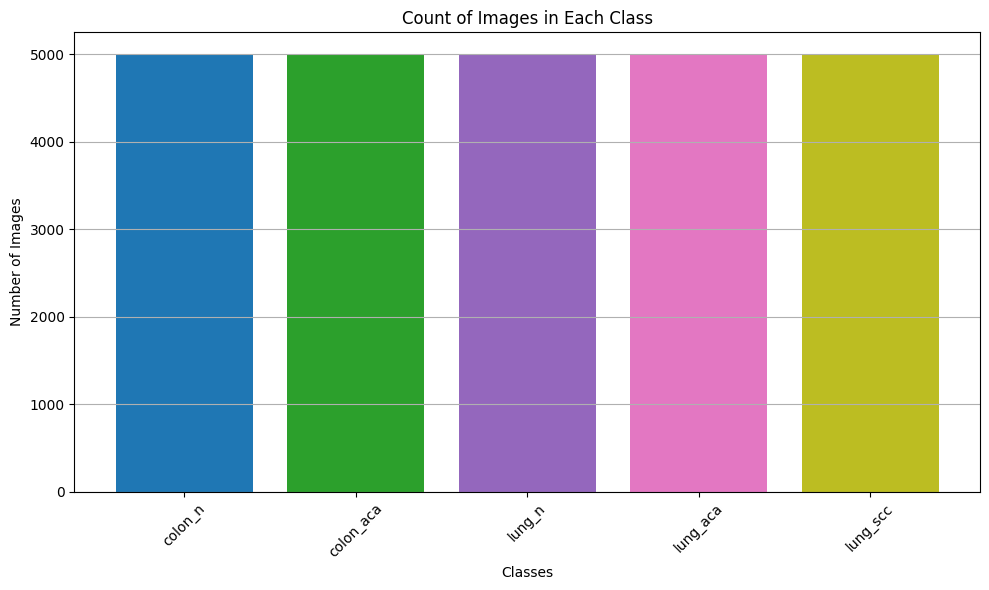

In [11]:
datasets = [COLON_SOURCE_DIR, LUNG_SOURCE_DIR]
class_countPlot(datasets)

In [12]:
split_data(COLON_SOURCE_DIR, TRAINING_DIR, TESTING_DIR, split_size)
split_data(LUNG_SOURCE_DIR, TRAINING_DIR, TESTING_DIR, split_size)

Testing if the split was done right on training and testing classes by taking random class in lung data and in colon data

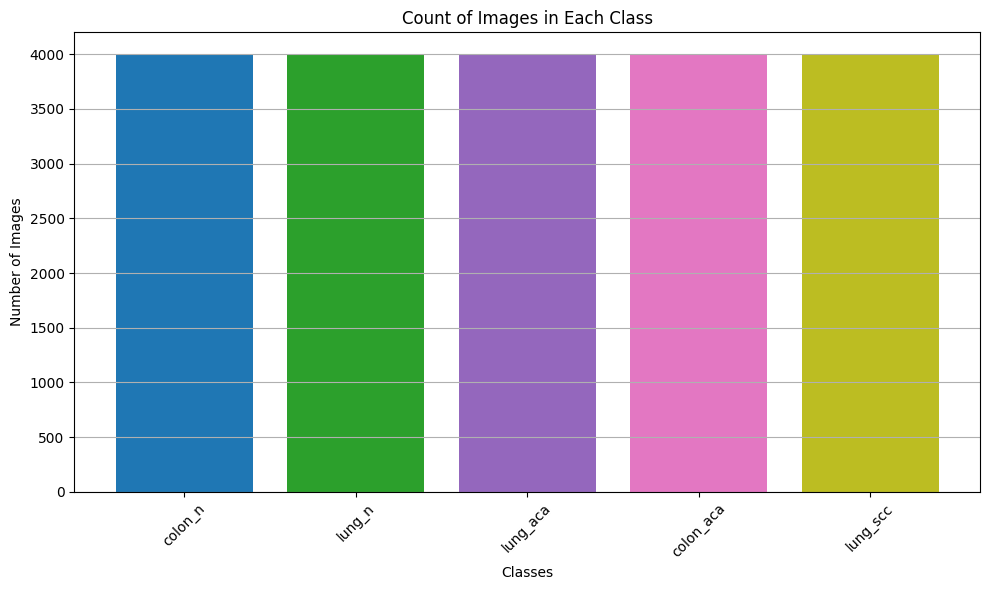

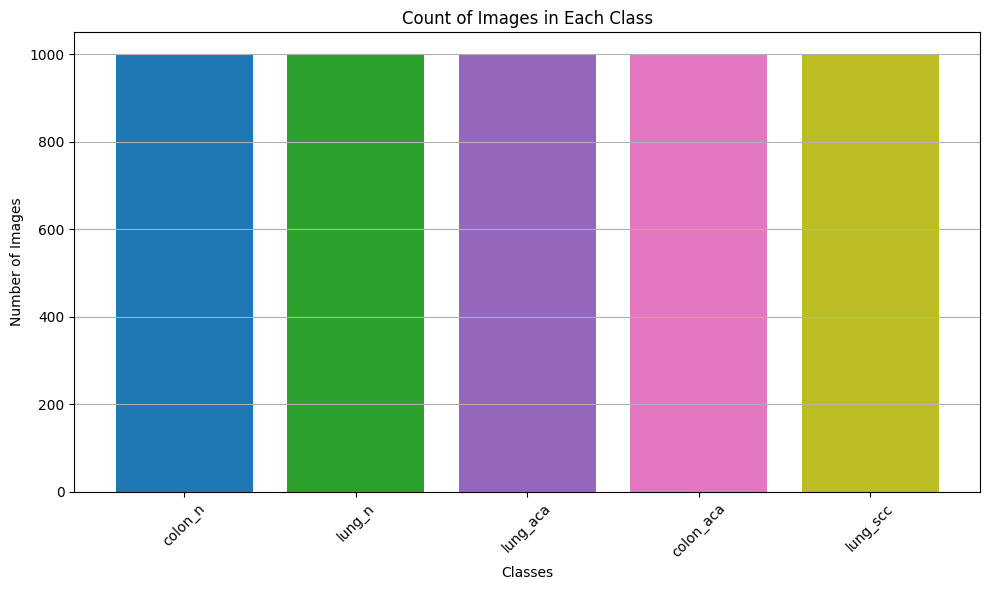

(None, None)

In [13]:
class_countPlot(TRAINING_DIR), class_countPlot(TESTING_DIR)

**Imaging a situation that we have to assign a category to an image based on it class. Using the augmentation assigns a category to the image, but it doesn't modify or affect the original data source**

In [14]:
# Make datagen for Train generator
train_datagen = ImageDataGenerator(rescale = 1./255, validation_split = 0.2)
test_datagen = ImageDataGenerator(rescale = 1./255)

# Train generator
train_generator = train_datagen.flow_from_directory(TRAINING_DIR, 
                                                    target_size = img_size,
                                                    batch_size = batch_size,
                                                    shuffle = True,
                                                    class_mode = "categorical",
                                                    color_mode = "rgb",
                                                    subset = "training"
                                                   )

# validation generator
validation_generator = train_datagen.flow_from_directory(TRAINING_DIR, 
                                                         target_size = img_size,
                                                         batch_size = batch_size,
                                                         shuffle = False,
                                                         class_mode = "categorical",
                                                         color_mode = "rgb",
                                                         subset = "validation"
                                                        )
# Test generator
test_generator = test_datagen.flow_from_directory(TESTING_DIR,
                                                  target_size = img_size,
                                                  batch_size = batch_size,
                                                  shuffle = False,
                                                  class_mode = "categorical",
                                                  color_mode = "rgb",
                                                 )

Found 16000 images belonging to 5 classes.
Found 4000 images belonging to 5 classes.
Found 5000 images belonging to 5 classes.


In [15]:
class_indices = train_generator.class_indices
class_names = list(class_indices.keys())

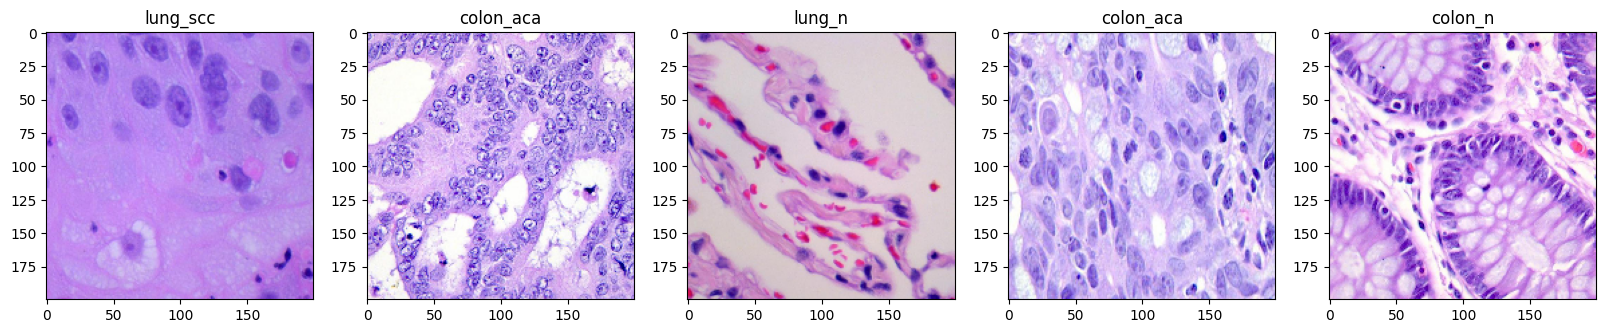

In [16]:
fig, axs = plt.subplots(1, 5, figsize = (20, 4))
axs = axs.flatten()
train_batch = next(train_generator)

for i ,ax in enumerate(axs):
    ax.imshow(train_batch[0][i])
    label = tf.argmax(train_batch[1][i])
    ax.set_title(class_names[label])
plt.show()

In [17]:
base_model = tf.keras.applications.DenseNet121(weights = "imagenet", include_top = False, pooling = "avg", input_shape = (img_size[0], img_size[1], 3))

29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [18]:
base_model.trainable = False

In [19]:
model = base_model.output
model = tf.keras.layers.BatchNormalization()(model)
model = tf.keras.layers.Dropout(0.5)(model)
model = tf.keras.layers.Dense(5, activation = "softmax")(model)
model = tf.keras.models.Model(inputs = base_model.input, outputs = model)

In [20]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 200, 200,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d      │ (None, 206, 206,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 100, 100,  │      9,408 │ zero_padding2d[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 100, 100,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 100, 100,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_1    │ (None, 102, 102,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1               │ (None, 50, 50,    │          0 │ zero_padding2d_1… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 50, 50,    │        256 │ pool1[0][0]       │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_relu │ (None, 50, 50,    │          0 │ conv2_block1_0_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 50, 50,    │      8,192 │ conv2_block1_0_r… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 50, 50,    │        512 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 50, 50,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 50, 50,    │     36,864 │ conv2_block1_1_r… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_concat │ (None, 50, 50,    │          0 │ pool1[0][0],      │
│ (Concatenate)       │ 96)               │            │ conv2_block1_2_c… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_bn   │ (None, 50, 50,    │        384 │ conv2_block1_con… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_relu │ (None, 50, 50,    │          0 │ conv2_block2_0_b… │
│ (Activation)        │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_1_conv │ (None, 50, 50,    │     12,288 │ conv2_block2_0_r

 Total params: 7,046,725 (26.88 MB)

 Trainable params: 7,173 (28.02 KB)

 Non-trainable params: 7,039,552 (26.85 MB)

In [21]:
model.compile(optimizer, loss= 'categorical_crossentropy', metrics= ['accuracy'])

In [22]:
history = model.fit(x= train_generator,
                    epochs= epochs,
                    verbose= 1,
                    validation_data= validation_generator,
                    callbacks= [early_stopping, model_checkpoint]
                    )

Epoch 1/100


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1728920895.014492     140 service.cc:145] XLA service 0x7c48f8005d90 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1728920895.014548     140 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0


 1/63 ━━━━━━━━━━━━━━━━━━━━ 40:03 39s/step - accuracy: 0.2109 - loss: 2.2614

I0000 00:00:1728920913.601965     140 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5563 - loss: 1.2207
Epoch 1: val_accuracy improved from -inf to 0.84975, saving model to DenseNet_noTop_MRI.keras
63/63 ━━━━━━━━━━━━━━━━━━━━ 161s 2s/step - accuracy: 0.5590 - loss: 1.2134 - val_accuracy: 0.8497 - val_loss: 0.6047
Epoch 2/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 874ms/step - accuracy: 0.8870 - loss: 0.3314
Epoch 2: val_accuracy improved from 0.84975 to 0.92825, saving model to DenseNet_noTop_MRI.keras
63/63 ━━━━━━━━━━━━━━━━━━━━ 78s 1s/step - accuracy: 0.8871 - loss: 0.3310 - val_accuracy: 0.9283 - val_loss: 0.3808
Epoch 3/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 920ms/step - accuracy: 0.9131 - loss: 0.2500
Epoch 3: val_accuracy improved from 0.92825 to 0.94500, saving model to DenseNet_noTop_MRI.keras
63/63 ━━━━━━━━━━━━━━━━━━━━ 82s 1s/step - accuracy: 0.9132 - loss: 0.2498 - val_accuracy: 0.9450 - val_loss: 0.2699
Epoch 4/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 858ms/step - accuracy: 0.9270 - loss: 0.2095
Epoch 4: val_accuracy improved fr

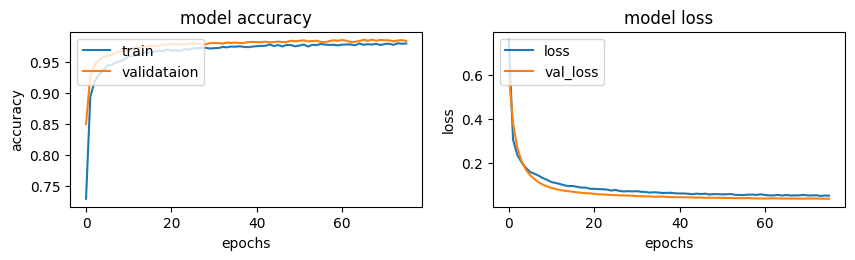

In [23]:
plot_accuracy_loss(history)

In [24]:
# Load the best weights after training  
model.load_weights("DenseNet_noTop_MRI.keras")  # Load the weights 

In [25]:
model.evaluate(test_generator)[1]

20/20 ━━━━━━━━━━━━━━━━━━━━ 33s 2s/step - accuracy: 0.9919 - loss: 0.0247 


0.9861999750137329

In [26]:
# Make predictions  
predictions = model.predict(test_generator)  

# If you want to extract class indices based on expectations  
predicted_classes = tf.argmax(predictions, axis=-1)  # Get predicted class indices

20/20 ━━━━━━━━━━━━━━━━━━━━ 35s 1s/step 


Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1000
           1       1.00      1.00      1.00      1000
           2       0.97      0.96      0.97      1000
           3       1.00      1.00      1.00      1000
           4       0.96      0.97      0.97      1000

    accuracy                           0.99      5000
   macro avg       0.99      0.99      0.99      5000
weighted avg       0.99      0.99      0.99      5000



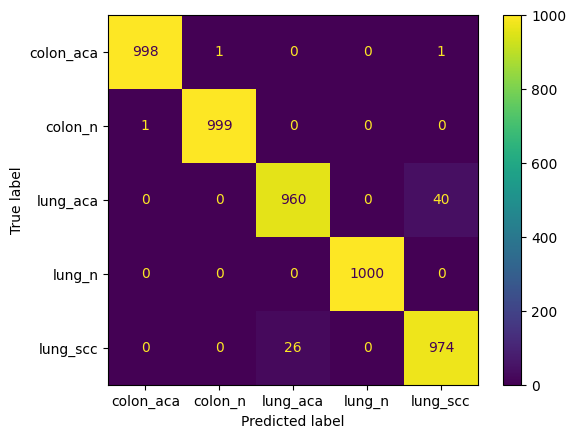

In [27]:
true_classes = test_generator.classes

print("Classification Report:")  
print(classification_report(true_classes, predicted_classes)) 

cm = confusion_matrix(true_classes, predicted_classes)
disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = class_names)
disp.plot()